In [12]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [13]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [14]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [15]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 16.52
ss.m_v = 0.23
ss.r_K = 0.14
ss.r_ell = 2.71
ss.ell = 55.87
ss.w = 2.68
ss.G = 100.00
ss.B_G = 50.00
ss.tau = 0.68
solving for household behavior: result.converged = True
ss.C = 49.27
ss.B = 119.18
ss.K = 557.43
ss.I = 55.74
ss.Y = 229.56
ss.X = nan
ss.M = nan
par.phi = 0.988


**Household behavior:**

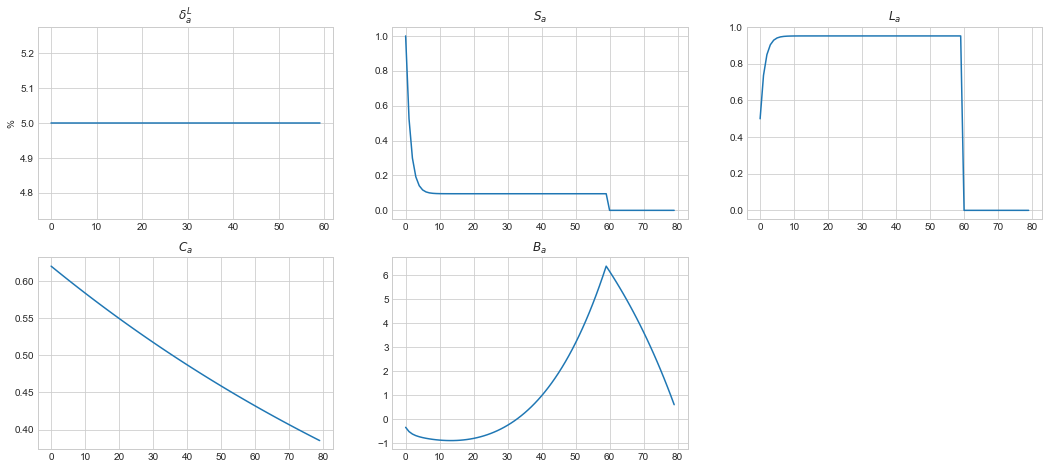

In [16]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

# Speed and error tests

In [17]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [18]:
%time model.evaluate_blocks(py=True)

CPU times: user 10 s, sys: 222 ms, total: 10.2 s
Wall time: 11.3 s


**Check errors:**

In [19]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max =      nan
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 7.11e-15
mkt_clearing        : abs. max =      nan
repacking_prices_C  : abs. max =      nan


**First numba evaluation:**

In [41]:
%time model.evaluate_blocks()

CPU times: user 46 s, sys: 1.21 s, total: 47.2 s
Wall time: 50.3 s


**Time:**

In [42]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

5.86 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
72.2 µs ± 918 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [43]:
%timeit model.evaluate_blocks(py=True)

493 ms ± 9.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [44]:
model.calc_jac(do_print=True)

Jacobian calculated in 19.6 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [45]:
model.set_exo_ss()

Here we shock export demand:

In [36]:
# Tshock = 50
# shock = 0.01*ss.chi
# persistence = 0.8**np.arange(Tshock)
# sol.chi[:Tshock] = ss.chi + shock*persistence

Here we shock the import price of consumption goods (P_M_C):

In [46]:
Tshock = 60
shock = 0.1*ss.P_M_C
persistence = 0.85**np.arange(Tshock)
sol.P_M_C[:Tshock] = ss.P_M_C + shock*persistence

In [38]:
def shock_func_ny(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8):
        shock_f = shock_size
        persistence_f = persistence_size ** np.arange(time_span)
        solvalue[time_start:time_start+time_span] = ssvalue + shock_f*persistence_f

In [39]:
# guide: shock_func(ssvalue, solvalue, time_start =0, time_span = 50, shock_size = 0.1, persistence_size =0.8)
shock_func_ny(ss.tau,sol.tau, shock_size = -0.1, persistence_size =0.5)

Check errors when guessing at steady state -> excess demand

In [47]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 0.00e+00
Bq_match            : abs. max =      nan
FOC_capital_agency  : abs. max = 0.00e+00
FOC_K_ell           : abs. max = 8.88e-15
mkt_clearing        : abs. max =      nan
repacking_prices_C  : abs. max =      nan


**Find IRF:**

In [48]:
model.find_IRF()

initial:
   max. abs. error =      nan
    0.00e+00 in bargaining_cond
         nan in Bq_match
    0.00e+00 in FOC_capital_agency
    8.88e-15 in FOC_K_ell
         nan in mkt_clearing
         nan in repacking_prices_C

it = 0
 solve: t1-t0 = 1.3 secs
   max. abs. error =      nan
         nan in bargaining_cond
         nan in Bq_match
         nan in FOC_capital_agency
         nan in FOC_K_ell
         nan in mkt_clearing
         nan in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 1
 solve: t1-t0 = 0.9 secs
   max. abs. error =      nan
         nan in bargaining_cond
         nan in Bq_match
         nan in FOC_capital_agency
         nan in FOC_K_ell
         nan in mkt_clearing
         nan in repacking_prices_C
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 2
 solve: t1-t0 = 0.8 secs
   max. abs. error =      nan
         nan in bargaining_cond
         nan in Bq_match
         nan in FOC_capital_agency
         nan in FO

Traceback (most recent call last):
  File "/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/67/5lclr44x13d7lzxtqq4c11r40000gn/T/ipykernel_2977/1601162382.py", line 1, in <cell line: 1>
    model.find_IRF()
  File "/Users/andreas/MAO/BabyMAKROModel.py", line 396, in find_IRF
    broyden_solver(obj,x0,self.jac,tol=1e-10,maxiter=100,do_print=True,model=self)
  File "/Users/andreas/MAO/broyden_solver.py", line 64, in broyden_solver
    raise ValueError(f'no convergence after {maxiter} iterations')
ValueError: no convergence after 100 iterations

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/andreas/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/andreas/opt/a

**Plot:**

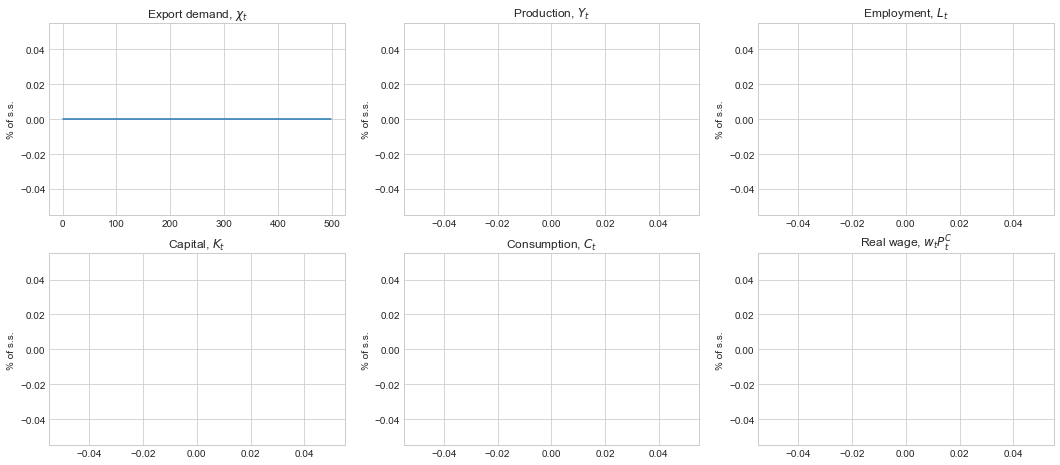

In [49]:
T_IRF = 500

fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot((sol.chi[:T_IRF]/ss.chi-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Export demand, $\chi_t$')

ax = fig.add_subplot(3,3,2)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Production, $Y_t$')

ax = fig.add_subplot(3,3,3)
ax.plot((sol.L[:T_IRF]/ss.L-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Employment, $L_t$')

ax = fig.add_subplot(3,3,4)
ax.plot((sol.K[:T_IRF]/ss.K-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$')

ax = fig.add_subplot(3,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(3,3,6)
ax.plot(((sol.w[:T_IRF]/sol.P_C[:T_IRF])/(ss.w/ss.P_C)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Real wage, $w_tP^C_t$');